In [1]:
import sys
sys.path.insert(0, "/kaggle/input/magnatagatune-pcm8-top50")
from magna_loader import MagnaLoader

In [2]:
mloader = MagnaLoader('/kaggle/input/magnatagatune-pcm8-top50/magnatagatune_pcm8_top50.bin')
mloader.samples_count

21108

In [3]:
import tensorflow as tf
import numpy as np
import gc

In [4]:
y_classes = 10
train_test_ratio = 0.9
test_x, test_y = [], []

def prepare_sample(x,y):
    x = x.reshape((-1, 1)) / 128
    y = y[:y_classes].astype(np.float32)
    return x,y

x_usage = np.zeros(mloader.samples_count, dtype=np.int8)
for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
    if sum(y)==0: continue
    if i<train_test_ratio*mloader.samples_count:
        x_usage[i] = 1
    else:
        x_usage[i] = 2
        test_x.append(x)
        test_y.append(y)
        
test_x = np.array(test_x)
test_y = np.array(test_y)
gc.collect()

train_count = sum(x_usage==1)
print("Train count =", train_count)

def magna_generator():        
    while True:
        for i, (x,y) in enumerate(mloader.iterate(prepare_sample)):
            if x_usage[i]==1:
                yield x,y        

Train count = 14837


In [5]:
test_x.shape, test_y.shape

((1635, 465984, 1), (1635, 10))

In [6]:
x_shape = (465984, 1)
y_shape = (y_classes,)

In [7]:
magna_dataset = tf.data.Dataset.from_generator(magna_generator, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=(x_shape, y_shape))
batch_size = 16
magna_dataset = magna_dataset.shuffle(150).batch(batch_size)

In [8]:
def create_cnnlstm_model():
    conv_cfg = {'kernel_size':(3,), 'padding':'same', 'activation':'leaky_relu'}
    x = x0 = tf.keras.layers.Input(x_shape)
    x = tf.keras.layers.Conv1D(32, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(64, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(128, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(128, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Conv1D(256, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv1D(256, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)    
    x = tf.keras.layers.Conv1D(512, **conv_cfg)(x)
    x = tf.keras.layers.MaxPooling1D(3)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
   
    x = tf.keras.layers.SimpleRNN(256)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation='leaky_relu')(x)    
    x = tf.keras.layers.Dropout(0.1)(x)    
    x = tf.keras.layers.Dense(y_shape[-1], activation='sigmoid')(x)

    return tf.keras.models.Model(x0, x)

model = create_cnnlstm_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 465984, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 465984, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 155328, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 155328, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 155328, 64)          │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 51776, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 51776, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 51776, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 17258, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 17258, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 17258, 128)          │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 5752, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 5752, 256)           │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 1917, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1917, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 1917, 256)           │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 639, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 639, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 639, 512)            │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 213, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 213, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 993,046 (3.79 MB)

 Trainable params: 993,046 (3.79 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [10]:
history = model.fit(magna_dataset, 
                   epochs=10,
                   steps_per_epoch=train_count//batch_size,
                   validation_data=(test_x, test_y))

Epoch 1/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 201s 195ms/step - binary_accuracy: 0.8104 - loss: 0.4407 - val_binary_accuracy: 0.8341 - val_loss: 0.3609
Epoch 2/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 167s 180ms/step - binary_accuracy: 0.8226 - loss: 0.4073 - val_binary_accuracy: 0.8357 - val_loss: 0.3599
Epoch 3/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 166s 179ms/step - binary_accuracy: 0.8221 - loss: 0.4103 - val_binary_accuracy: 0.8371 - val_loss: 0.3545
Epoch 4/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 166s 179ms/step - binary_accuracy: 0.8252 - loss: 0.4003 - val_binary_accuracy: 0.8352 - val_loss: 0.3624
Epoch 5/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 165s 178ms/step - binary_accuracy: 0.8228 - loss: 0.4027 - val_binary_accuracy: 0.8377 - val_loss: 0.3541
Epoch 6/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 165s 178ms/step - binary_accuracy: 0.8243 - loss: 0.3997 - val_binary_accuracy: 0.8388 - val_loss: 0.3578
Epoch 7/10
927/927 ━━━━━━━━━━━━━━━━━━━━ 165s 178ms/step - binary_accuracy: 0.8255 - loss: 0.3999 - val_binary_accuracy: 0.83

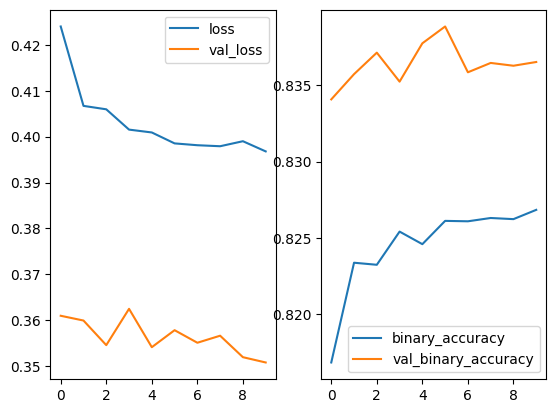

In [11]:
from matplotlib import pyplot as plt
fix, ax = plt.subplots(1,2)

ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['binary_accuracy'], label='binary_accuracy')
ax[1].plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
ax[1].legend()
plt.show()

In [12]:
del magna_dataset
gc.collect()

851

In [13]:
from sklearn.metrics import roc_curve
y_pred = model.predict(test_x)

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step


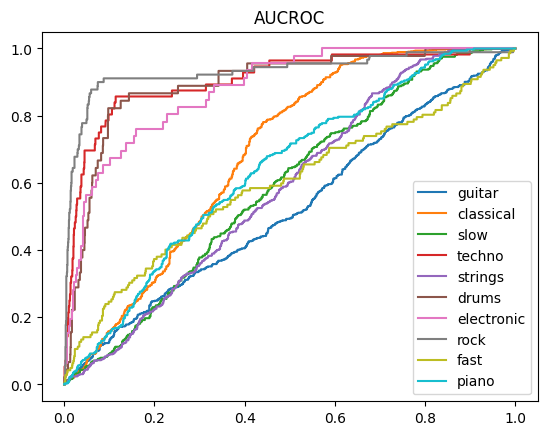

In [14]:
classes=["guitar", "classical", "slow", "techno", "strings", "drums", 
         "electronic", "rock", "fast", "piano"]
F = [None]*y_classes
T = [None]*y_classes
for i in range(y_classes):
    F[i], T[i], ths = roc_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(F[i], T[i], label=classes[i])
plt.legend()
plt.title("AUCROC")
plt.show()

In [15]:
def auc(x,y):
    s = 0
    for i in range(1, len(x)):
        s += (y[i]+y[i-1])*abs((x[i]-x[i-1]))/2
    return s
for g, a in [(classes[i], auc(F[i], T[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.522341943726996
classical 0.6883881604171458
slow 0.5859421853090281
techno 0.9061962815525197
strings 0.583531780676368
drums 0.8956883298392734
electronic 0.8793060989958136
rock 0.9311003236245955
fast 0.5919832457571954
piano 0.6380940355940355


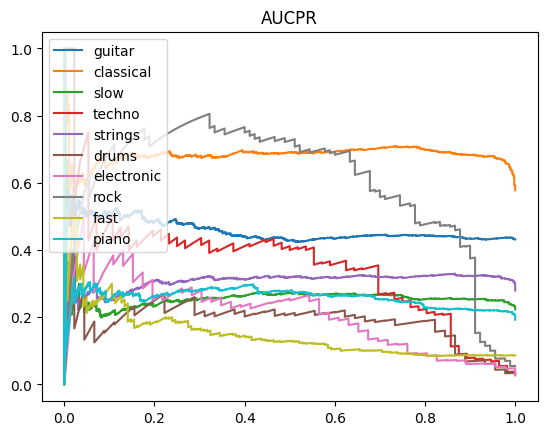

In [16]:
from sklearn.metrics import precision_recall_curve
P = [None]*y_classes
R = [None]*y_classes
for i in range(y_classes):
    P[i], R[i], ths = precision_recall_curve(test_y[:,i], y_pred[:,i], pos_label=1)
    plt.plot(R[i], P[i], label=classes[i])
plt.legend()
plt.title("AUCPR")
plt.show()

In [17]:
for g, a in [(classes[i], auc(R[i], P[i])) for i in range(y_classes)]:
    print(g,a)

guitar 0.4577372845422078
classical 0.6833177142071362
slow 0.2573871256910848
techno 0.3390897977310822
strings 0.3100520192127691
drums 0.20240149548383868
electronic 0.20658049994383806
rock 0.5948881399660022
fast 0.146474501293493
piano 0.2591766311613909


In [18]:
from sklearn.metrics import confusion_matrix

for i in range(y_classes):
    print(classes[i])    
    cmat = confusion_matrix(test_y[:,i], y_pred[:,i]>=0.5)    
    print(cmat)
    p = cmat[0,0]/(cmat[0,0]+cmat[1,0])
    r = cmat[0,0]/(cmat[0,0]+cmat[0,1])
    print("Accuracy =", (cmat[0,0]+cmat[1,1])/(cmat[0,0]+cmat[0,1]+cmat[1,0]+cmat[1,1]))
    print("Prec =", p)
    print("Recall =", r)    
    print("F1 = ", 2*p*r/(p+r))

guitar
[[900  29]
 [675  31]]
Accuracy = 0.5694189602446483
Prec = 0.5714285714285714
Recall = 0.9687836383207751
F1 =  0.7188498402555911
classical
[[245 445]
 [ 34 911]]
Accuracy = 0.7070336391437309
Prec = 0.8781362007168458
Recall = 0.35507246376811596
F1 =  0.5056759545923634
slow
[[1270    0]
 [ 365    0]]
Accuracy = 0.7767584097859327
Prec = 0.7767584097859327
Recall = 1.0
F1 =  0.874354561101549
techno
[[1571    8]
 [  49    7]]
Accuracy = 0.9651376146788991
Prec = 0.9697530864197531
Recall = 0.9949335022165928
F1 =  0.9821819318537044
strings
[[1178    0]
 [ 457    0]]
Accuracy = 0.7204892966360856
Prec = 0.7204892966360856
Recall = 1.0
F1 =  0.8375399928901529
drums
[[1590    0]
 [  45    0]]
Accuracy = 0.9724770642201835
Prec = 0.9724770642201835
Recall = 1.0
F1 =  0.986046511627907
electronic
[[1589    0]
 [  46    0]]
Accuracy = 0.9718654434250764
Prec = 0.9718654434250764
Recall = 1.0
F1 =  0.9857320099255583
rock
[[1528   17]
 [  46   44]]
Accuracy = 0.9614678899082569
P